# Segmenting and Clustering Neighborhoods in Toronto
#### *Jupyter-Notebook for the Capstone Project of IBM's Professional Certificate in Data Science*

## Part 1 of the final submission

In [1]:
# import required libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup

#### Scraping Toronto's postal code data from Wikipedia page

Get the required Wikipedia page

In [2]:
html = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

Create a "beautiful soup"-object using the text of the requested Wikipedia page

In [3]:
soup = BeautifulSoup(html.text, 'lxml')

Extract the table of postal codes from the soup object

In [4]:
table = soup.find('table')

Read the extracted HTML-table into the pandas dataframe 'toronto_hoods'

In [5]:
toronto_hoods = pd.read_html(str(table))[0]

#### Cleaning the data according to the instructions

Rename columns according to instructions

In [6]:
toronto_hoods.columns = ['PostalCode', 'Borough', 'Neighborhood']

Remove all rows, i.e. postal codes, for which no borough has been assigned

In [7]:
toronto_hoods = toronto_hoods[toronto_hoods.Borough != 'Not assigned']

Combine neighborhoods that share a postal code

In [8]:
toronto_hoods = toronto_hoods.groupby(['PostalCode','Borough'], sort=False).agg(', '.join)
toronto_hoods.reset_index(inplace=True)

Use borough labels to fill up missing neighborhood labels

In [9]:
toronto_hoods['Neighborhood'].replace('Not assigned', toronto_hoods['Borough'], inplace=True)

#### Additional data cleaning 

There are duplicates among the neigborhood labels:

In [10]:
print("---------------------------------------------------------------------------")
print("Duplicate Neighborhood Labels:\n\n",toronto_hoods['Neighborhood'].value_counts(),"\n")
print("---------------------------------------------------------------------------")

---------------------------------------------------------------------------
Duplicate Neighborhood Labels:

 Downsview                                                                                         4
Don Mills                                                                                         2
Northwest, West Humber - Clairville                                                               1
Commerce Court, Victoria Hotel                                                                    1
Bedford Park, Lawrence Manor East                                                                 1
                                                                                                 ..
Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West    1
Little Portugal, Trinity                                                                          1
Del Ray, Mount Dennis, Keelsdale and Silverthorn                                           

Add numbers to distinguish between different postal code areas of a neighborhood

In [11]:
toronto_hoods['duplicates'] = toronto_hoods['Neighborhood'].duplicated(keep=False)
toronto_hoods['duplicate_count'] = toronto_hoods.groupby(['Neighborhood']).cumcount()
toronto_hoods['Neighborhood'] = (toronto_hoods['Neighborhood'] + toronto_hoods['duplicate_count'][toronto_hoods['duplicate_count']>0].astype(str)).fillna(toronto_hoods['Neighborhood'])

Check outcome of the numbering procedure

In [12]:
toronto_hoods[toronto_hoods['duplicates'] == True]

,PostalCode,Borough,Neighborhood,duplicates,duplicate_count
7,M3B,North York,Don Mills,True,0
13,M3C,North York,Don Mills1,True,1
40,M3K,North York,Downsview,True,0
46,M3L,North York,Downsview1,True,1
53,M3M,North York,Downsview2,True,2
60,M3N,North York,Downsview3,True,3


Delete auxiliary variables 'duplicates' and 'duplicate_count'

In [13]:
toronto_hoods.drop(['duplicates', 'duplicate_count'], axis = 1, inplace = True)

#### Final inspection of the resulting data set

In [14]:
toronto_hoods.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [15]:
print("The data set contains",toronto_hoods.shape[0],"rows, i.e. neighborhoods")

The data set contains 103 rows, i.e. neighborhoods







## Part 2 of the final submission

#### Load the prepared geospatial data on Toronto's neighborhoods

In [16]:
!wget -O geospatial_data.csv "https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv"

--2020-10-21 16:44:22--  https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv
Resolving cocl.us (cocl.us)... 169.63.96.148, 169.63.96.51
Connecting to cocl.us (cocl.us)|169.63.96.148|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-10-21 16:44:23--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 185.235.236.197
Connecting to ibm.box.com (ibm.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-10-21 16:44:23--  https://ibm.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/9afzr83pps4pwf2smjjcf

#### Read geospatial data as pandas data frame

In [17]:
coordinates = pd.read_csv("geospatial_data.csv")
coordinates.sort_values('Postal Code')
coordinates

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


#### Merge postal code data and geospatial data

In [18]:
toronto_hoods = pd.merge(toronto_hoods, coordinates, left_on='PostalCode', right_on='Postal Code', how='left').drop('Postal Code', axis=1)

#### Inspection of the merged data set

In [19]:
toronto_hoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [20]:
toronto_hoods.shape

(103, 5)

## Part 3 of the final submission

### *In this part of the submission I first use the foursquare API to explore venues within walking distance (500 m) of the different neighborhoods. Subsequently, I cluster neighborhoods based on their venue profile*

#### Specify foursquare credentials

In [21]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = 20201015

#### Collect information on venues within walking distance (500 m) of the different neighborhoods

In [22]:
def getNearbyVenues(names, latitudes, longitudes, LIMIT=100, radius=500):
    
    venues_list=[]
    i=0
    for name, lat, lng in zip(names, latitudes, longitudes):
        i=i+1
        print(i)
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
toronto_venues = getNearbyVenues(names=toronto_hoods['Neighborhood'],
                                latitudes=toronto_hoods['Latitude'],
                                longitudes=toronto_hoods['Longitude']
                                )

1
Parkwoods
2
Victoria Village
3
Regent Park, Harbourfront
4
Lawrence Manor, Lawrence Heights
5
Queen's Park, Ontario Provincial Government
6
Islington Avenue, Humber Valley Village
7
Malvern, Rouge
8
Don Mills
9
Parkview Hill, Woodbine Gardens
10
Garden District, Ryerson
11
Glencairn
12
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
13
Rouge Hill, Port Union, Highland Creek
14
Don Mills1
15
Woodbine Heights
16
St. James Town
17
Humewood-Cedarvale
18
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
19
Guildwood, Morningside, West Hill
20
The Beaches
21
Berczy Park
22
Caledonia-Fairbanks
23
Woburn
24
Leaside
25
Central Bay Street
26
Christie
27
Cedarbrae
28
Hillcrest Village
29
Bathurst Manor, Wilson Heights, Downsview North
30
Thorncliffe Park
31
Richmond, Adelaide, King
32
Dufferin, Dovercourt Village
33
Scarborough Village
34
Fairview, Henry Farm, Oriole
35
Northwood Park, York University
36
East Toronto, Broadview North (Old East York)
37
Harbour

In [24]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [25]:
print("The data frame 'toronto_venues' contains",toronto_venues.shape[0],"venues.")
print("The data covers",len(toronto_venues['Venue Category'].unique()),"different venue categories and contains information for",len(toronto_venues['Neighborhood'].unique()),"different neighborhoods") 

The data frame 'toronto_venues' contains 2136 venues.
The data covers 273 different venue categories and contains information for 100 different neighborhoods


#### During one-hot encoding (next step) it appears that there are venues with the category label "Neighborhood". For clarification, the venue category "Neighborhood" is relabeled as "Neighborhood_vencat"

In [26]:
check = toronto_venues[toronto_venues["Venue Category"] == "Neighborhood"]
check

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
354,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
604,"Richmond, Adelaide, King",43.650571,-79.384568,Downtown Toronto,43.653232,-79.385296,Neighborhood
789,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Harbourfront,43.639526,-79.380688,Neighborhood
1267,Studio District,43.659526,-79.340923,Leslieville,43.662070,-79.337856,Neighborhood


In [27]:
toronto_venues["Venue Category"].replace("Neighborhood", "Neighborhood_vencat", inplace = True)

#### One-hot encoding in preparation for the clustering procedure

In [28]:
# generate one-hot encoded dataset on venue categories
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add the variable "Neighborhood"
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

# change the order of columns
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

In [29]:
toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
print("The data frame 'toronto_onehot' contains one-hot encoded data on",toronto_onehot.shape[0],"venues.")
print("The data covers",toronto_onehot.shape[1]-1,"different venue categories and contains information for",len(toronto_onehot['Neighborhood'].unique()),"different neighborhoods") 

The data frame 'toronto_onehot' contains one-hot encoded data on 2136 venues.
The data covers 273 different venue categories and contains information for 100 different neighborhoods


#### Collapse one-hot encoded data on the neighborhood level

In [31]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [32]:
toronto_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
print("The data frame 'toronto_grouped' collapses one-hot encoded data on",toronto_grouped.shape[0],"venues on the neighborhood level.")
print("The data covers",toronto_grouped.shape[1]-1,"different venue categories and contains information for",len(toronto_onehot['Neighborhood'].unique()),"different neighborhoods, i.e. rows") 

The data frame 'toronto_grouped' collapses one-hot encoded data on 100 venues on the neighborhood level.
The data covers 273 different venue categories and contains information for 100 different neighborhoods, i.e. rows


#### Summarize the most common venue categories for each neighborhood 

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

In [36]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Clothing Store,Lounge,Breakfast Spot,Skating Rink,Latin American Restaurant,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Coffee Shop,Pub,Pharmacy,Gym,Greek Restaurant,Discount Store,Department Store,Dessert Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Ice Cream Shop,Bridal Shop,Shopping Mall,Sandwich Place,Diner,Middle Eastern Restaurant,Restaurant
3,Bayview Village,Japanese Restaurant,Café,Chinese Restaurant,Bank,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Greek Restaurant,Thai Restaurant,Locksmith,Liquor Store,Comfort Food Restaurant,Juice Bar,Butcher


In [37]:
print("The data frame 'neighborhoods_venues_sorted' states the", neighborhoods_venues_sorted.shape[1]-1,"most common venues for each neighborhood.")
print("The data covers information for",len(neighborhoods_venues_sorted['Neighborhood'].unique()),"different neighborhoods, i.e. rows")

The data frame 'neighborhoods_venues_sorted' states the 10 most common venues for each neighborhood.
The data covers information for 100 different neighborhoods, i.e. rows


#### Identify the optimal number of clusters for k-means

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def calculate_WCSSE_sil(points, kmax):
  global wcsse
  wcsse = []
  global sil
  sil = []
  for k in range(2, kmax+1):
    
    kmeans = KMeans(n_clusters = k, random_state=0).fit(points)
    
    ## calculate the within-cluster-sum of squared errors (WCSSE)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_wcsse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WCSSE
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_wcsse += (np.linalg.norm(points[i] - curr_center)) ** 2

    wcsse.append(curr_wcsse)
    
    ## calculate silhouette values
    labels = kmeans.labels_
    sil.append(silhouette_score(toronto_grouped_clustering_mat, labels, metric = 'euclidean'))


In [39]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

toronto_grouped_clustering_mat= 100*toronto_grouped_clustering.to_numpy()

calculate_WCSSE_sil(toronto_grouped_clustering_mat, 15)

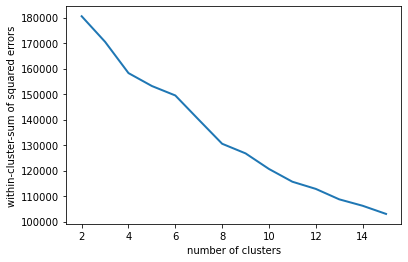

In [40]:
import matplotlib.pyplot as plt
k = range(2,16)
plt.plot(k, wcsse, linewidth=2.0)
plt.xlabel('number of clusters')
plt.ylabel('within-cluster-sum of squared errors')
plt.show()

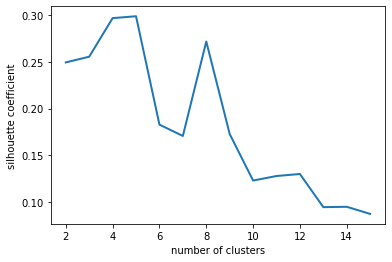

In [41]:
plt.plot(k, sil, linewidth=2.0)
plt.xlabel('number of clusters')
plt.ylabel('silhouette coefficient')
plt.show()

The within-cluster-sum of squared errors (WCSSE) does not show any notable "elbow point". However, the silhouette coefficient is maximized at k=5. Therefore, k-means clusters will be fit using k=5.

#### Fitting k-means clusters with k=5

In [42]:
print("The silhouette coefficient is maximized at k=",np.argmax(sil, axis=0)+2)
kclusters_opt=np.argmax(sil, axis=0)+2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters_opt, random_state=0).fit(toronto_grouped_clustering_mat)

# check cluster labels generated for each row in the dataframe
np.array(np.unique(kmeans.labels_, return_counts=True)).T

The silhouette coefficient is maximized at k= 5


array([[ 0, 86],
       [ 1, 10],
       [ 2,  1],
       [ 3,  2],
       [ 4,  1]], dtype=int64)

#### Prepare the final dataset containig postal codes, geospatial data, venue categories and cluster labels

In [43]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_hoods

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [44]:
# Three neighborhoods have NaN as they do not have any venues within a radius of 500 m from the centroid
print("Initial size of the data frame:",toronto_merged.shape)
toronto_merged[toronto_merged.isnull().any(axis=1)]

# Remove neighborhoods without venues
toronto_merged.dropna(axis=0, inplace = True)

Initial size of the data frame: (103, 16)


In [45]:
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1.0,Park,Food & Drink Shop,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Pizza Place,Hockey Arena,Coffee Shop,Portuguese Restaurant,Intersection,Construction & Landscaping,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Escape Room
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,Spa,Brewery,Shoe Store
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Clothing Store,Accessories Store,Boutique,Gift Shop,Furniture / Home Store,Event Space,Coffee Shop,Women's Store,Vietnamese Restaurant,Airport Service
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.0,Coffee Shop,Yoga Studio,College Auditorium,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Café,Restaurant,Chinese Restaurant


In [46]:
print("Final size of the data frame:",toronto_merged.shape)

Final size of the data frame: (100, 16)


#### Plot the distribution of clusters

In [47]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
import folium

toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

# get the coordinates of Toronto
nominatim_inst = Nominatim(user_agent = "foursquare_agent")
coord_toronto = nominatim_inst.geocode('Toronto')

# create map
toronto_map_clusters = folium.Map(location=[coord_toronto.latitude, coord_toronto.longitude], zoom_start=10)


# set color scheme for the clusters
x = np.arange(kclusters_opt)
ys = [i + x + (i*x)**2 for i in range(kclusters_opt)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(toronto_map_clusters)
       
toronto_map_clusters